# Solutions for Lesson 2: Issues in Practice

Don't look at this notebook until you have attempted to solve the problems yourself.

<br><br><br><br><br>

## Which library to use?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import sklearn.linear_model
import torch
from torch import nn, optim

In [2]:
penguins_df = pd.read_csv("../data/penguins.csv")

In [3]:
boston_prices_df = pd.read_csv(
    "../data/boston-house-prices.csv", sep="\s+", header=None,
    names=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"],
)
boston_prices_df = (boston_prices_df - boston_prices_df.mean()) / boston_prices_df.std()

In [4]:
stockmarket_data = [float(x) for x in open("../data/nasdaq-NXPI-20160726-to-20170428.csv")]

<br><br><br><br><br>

## Regression versus classification, loss functions

...

### Categorical → numerical and numerical → categorical

...

### Classification in PyTorch

In [5]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"][["bill_length_mm", "bill_depth_mm"]].dropna()

In [6]:
species = np.concatenate([np.zeros(len(adelie_df)), np.ones(len(gentoo_df))])
bill_depth = np.concatenate([adelie_df["bill_depth_mm"].values, gentoo_df["bill_depth_mm"].values])

In [7]:
# this user-defined model step centers and scales the input
# without this, the optimizer would require many more steps to find the minimum
class NormalizeInput(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(bill_depth.mean(), bill_depth.std())

model = nn.Sequential(      # define a 3-step model
    normalize_input,        # step 1: center/scale the input
    nn.Linear(1, 1),        # step 2: linear transformation (1D → 1D)
    nn.Sigmoid(),           # step 3: pass output through a sigmoid
)

# convert the data into PyTorch Tensors, which are differentiable and can live on a GPU
features = torch.tensor(bill_depth[:, np.newaxis], dtype=torch.float32)
targets = torch.tensor(species[:, np.newaxis], dtype=torch.float32)

# use Binary Cross Entropy as a loss function
loss_function = nn.BCELoss()

# use Adam as an optimizer with a (high) learning rate of 0.03
optimizer = optim.Adam(model.parameters(), lr=0.03)

# iterate over the same data 1000 times (epochs)
for epoch in range(1000):
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # give the model the input features and ask it to compute its predictions
    predictions = model(features)

    # compute the loss between these predictions and the intended targets
    loss = loss_function(predictions, targets)

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

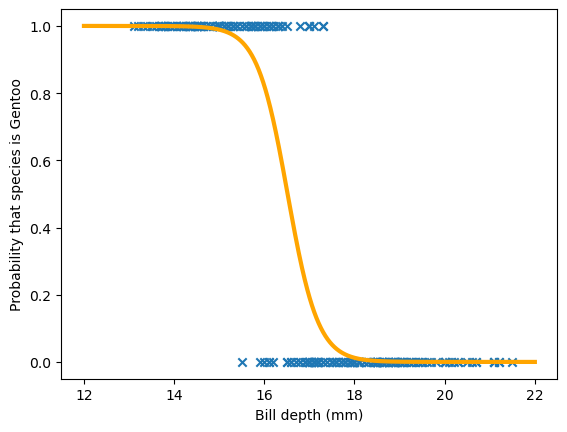

In [8]:
model_x = np.linspace(12, 22, 1000)
model_y = model(torch.tensor(model_x[:, np.newaxis], dtype=torch.float32)).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

### More than two classes

In [9]:
adelie_df["is_adelie"] = 1
gentoo_df["is_gentoo"] = 1
chinstrap_df["is_chinstrap"] = 1

onehot_df = pd.concat([adelie_df, gentoo_df, chinstrap_df]).fillna(0)

In [10]:
features_np = onehot_df[["bill_length_mm", "bill_depth_mm"]].values
targets_np = onehot_df[["is_adelie", "is_gentoo", "is_chinstrap"]].values

<br><br><br><br><br>

### 5-minute exercise: do a logistic regression of 2 features to 3 categories in PyTorch

Uncomment and run the debugging code if it's helpful to do so.

Remember: examine all your variables and look at each step! That's why we're using Python (and Jupyter) in the first place!

In [11]:
features = torch.tensor(features_np, dtype=torch.float32)
targets = torch.tensor(targets_np, dtype=torch.float32)

In [12]:
# features

In [13]:
# targets

In [14]:
class NormalizeInput(nn.Module):
    def __init__(self, mean1, std1, mean2, std2):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean1, mean2], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std1, std2], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(
    features_np[:, 0].mean(), features_np[:, 0].std(),
    features_np[:, 1].mean(), features_np[:, 1].std(),
)
# normalize_input.forward(features)

The softmax function is defined as:

$$ \mbox{softmax}_i(x) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$

Consequentially,

$$ \sum_i \mbox{softmax}_i(x) = 1 $$

When we had only 2 categories, we could focus on only one of them and compute its sigmoid.

With 3 categories, we use the softmax to ensure that the model's output probabilities add to 1.

In [15]:
model_without_softmax = nn.Sequential(
    normalize_input,
    nn.Linear(2, 3),
)
# model_without_softmax

In [16]:
# model_without_softmax(features)

In [17]:
model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)
# model_with_softmax

In [18]:
# model_with_softmax(features)

In the next cell, define a `loss_function`, an `optimizer`, and implement the fit.

Use PyTorch's [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which internally includes the softmax. Don't apply it twice!

In [19]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

for epoch in range(1000):
    optimizer.zero_grad()

    predictions = model_without_softmax(features)

    loss = loss_function(predictions, targets)

    loss.backward()
    optimizer.step()

The next cell plots the fit, just like Scikit-Learn, using the model with the softmax (because we need to plot probabilities).

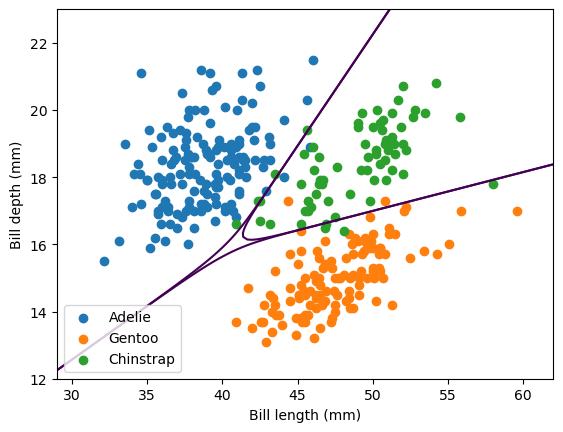

In [20]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model_with_softmax(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

## Optimizers: learning rate, epochs, mini-batches

...

### 5-minute exercise: optimize a 2D function

In [21]:
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# a PyTorch "model" that just consists of two optimizable parameters
class Position2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.xy = nn.Parameter(torch.tensor([-1, 2], dtype=torch.float32, requires_grad=True))
    def forward(self):
        return self.xy[0], self.xy[1]

Define a optimizer than can find the true minimum of (3, 0.5), replacing the naive one in this cell:

In [22]:
model = Position2D()

optimizer = optim.Adam(model.parameters(), lr=0.3, betas=(0.99, 0.999))

In [23]:
path_start = list(model.parameters())[0].detach().numpy().tolist()

path = [path_start]
for epoch in range(1000):

    # start an optimization step in the usual way
    optimizer.zero_grad()

    # this model has no arguments, and its loss function is beale (unusual!)
    loss = beale(*model())

    # finish an optimization step in the usual way
    loss.backward()
    optimizer.step()

    # keep track of the path, to plot it
    path.append(list(model.parameters())[0].detach().numpy().tolist())

path_np = np.array(path)

print("Final position, should be (3, 0.5):")
print(list(model.parameters())[0])
print()
print("Final loss, should be 0:")
print(loss)

Final position, should be (3, 0.5):
Parameter containing:
tensor([3.0190, 0.5036], requires_grad=True)

Final loss, should be 0:
tensor(5.6613e-05, grad_fn=<AddBackward0>)


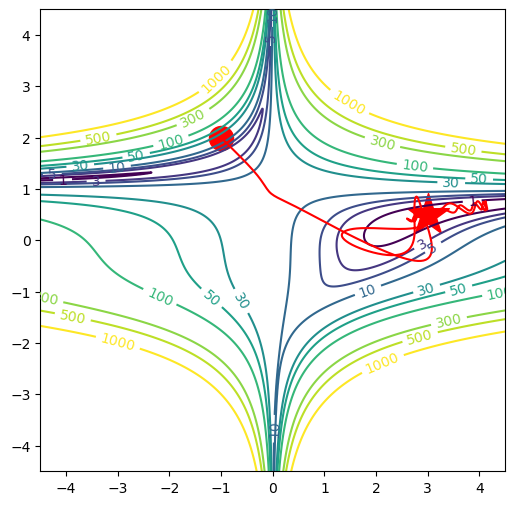

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

background_x, background_y = np.meshgrid(np.linspace(-4.5, 4.5, 1000), np.linspace(-4.5, 4.5, 1000))
contours = ax.contour(background_x, background_y, beale(background_x, background_y), [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000], norm="log")
ax.clabel(contours, contours.levels)
ax.axis([-4.5, 4.5, -4.5, 4.5])

ax.scatter([3], [0.5], marker="*", s=1000, c="red")
ax.scatter([path_start[0]], [path_start[1]], marker="o", s=300, c="red")
ax.plot(path_np[:, 0], path_np[:, 1], c="red")

None

### Epochs and mini-batches

...

<br><br><br><br><br>

## Feature selection and the "kernel trick"

...

<br><br><br><br><br>

## Under & overfitting

...

<br><br><br><br><br>

## Regularization: L1, L2, dropout

### 5-minute exercise: L1 and L2 regularization

Given the ridiculously overfit network below (click on the image),

1. add an L1 regularization term with a big enough coefficient to simplify the model,
2. do the same with an L2 regularization term.

Do you notice anything different in the resulting matrix weights (the lines between the layers)?

(Notice the plot in the upper right: it is loss versus time for the training sample and an independent test sample. See how they diverge.)

<a href="https://playground.tensorflow.org/#activation=relu&batchSize=5&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=50&networkShape=8,8,8,8,8,8&seed=0.66131&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false"><img src="../img/ridiculously-overfitted.png" width="800"></a>

1. For L1, 0.003‒0.03 will do it, but outside that range is too little or too much.
2. For L2, 0.01‒0.1 will do it, but outside that range is too little or too much.

L1 regularization is more of a hard cut: it makes the unused weights nearly zero. This method could be used to decide which neurons to actually remove, so that they don't need to be computed anymore.

L2 regularization is more soft: it minimizes but doesn't eliminate unnecessary weights.

<br><br><br><br><br>

### 5-minute exercise: dropout regularization

Another way to regularize the model is to actually remove parameters from the network.

The "dropout" technique removes inputs to a layer randomly.

In this exercise, use [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) to add dropout regularization to the overfit network below. (Don't worry about optimizing it; just try different values and see what it does.)

In [25]:
model_without_softmax = nn.Sequential(
    normalize_input,
    nn.Linear(2, 10),    # the first linear layer is enough
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(10, 10),   # this 10-neuron hidden layer is unnecessary
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(10, 3),    # this 10-neuron hidden layer is unnecessary
)

model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)

In [26]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

for epoch in range(1000):
    optimizer.zero_grad()

    predictions = model_without_softmax(features)

    loss = loss_function(predictions, targets)

    loss.backward()
    optimizer.step()

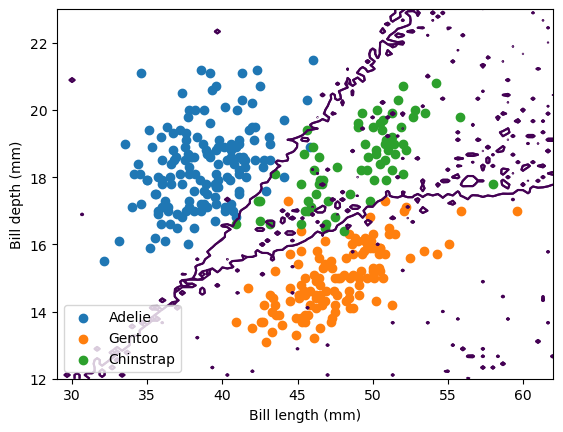

In [27]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model_with_softmax(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

## Parameters versus hyperparameters

...

<br><br><br><br><br>

## Partitioning data into training, validation, and test samples

### 5-minute exercise: plot loss versus epoch

In the following, replace the `...` in

```python
    training_loss_vs_epoch.append(...)   # FILL IN HERE!
    test_loss_vs_epoch.append(...)       # FILL IN HERE!
```

with the appropriate code to make loss-versus-epoch plots, separately for training and test samples.

In [28]:
all_target = np.random.randint(0, 2, 200)

all_xy = np.random.normal(-0.5, 0.75, (len(all_target), 2))
all_xy[all_target == 1] = np.random.normal(0.5, 0.75, (np.count_nonzero(all_target), 2))

In [29]:
training_target = torch.tensor(all_target[:100])
training_xy = torch.tensor(all_xy[:100]).float()

test_target = torch.tensor(all_target[100:])
test_xy = torch.tensor(all_xy[100:]).float()

In [30]:
model_without_softmax = nn.Sequential(
    nn.Linear(2, 10),    # the first linear layer is enough
    nn.ReLU(),
    nn.Linear(10, 10),   # this 10-neuron hidden layer is unnecessary
    nn.ReLU(),
    nn.Linear(10, 2),    # this 10-neuron hidden layer is unnecessary
)

# # this linear model would avoid overfitting
# model_without_softmax = nn.Sequential(
#     nn.Linear(2, 2),
# )

model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_without_softmax.parameters(), lr=0.03)

training_loss_vs_epoch = []
test_loss_vs_epoch = []

for epoch in range(1000):
    training_loss_vs_epoch.append(loss_function(model_without_softmax(training_xy), training_target).item())
    test_loss_vs_epoch.append(loss_function(model_without_softmax(test_xy), test_target).item())

    optimizer.zero_grad()

    predictions = model_without_softmax(training_xy)

    loss = loss_function(predictions, training_target)

    loss.backward()
    optimizer.step()

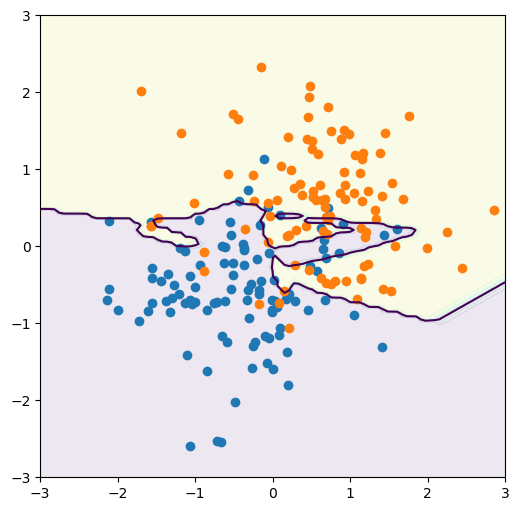

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model_with_softmax(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contourf(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), alpha=0.1)

# draw data points on top
ax.scatter(all_xy[all_target == 0, 0], all_xy[all_target == 0, 1])
ax.scatter(all_xy[all_target == 1, 0], all_xy[all_target == 1, 1])

ax.axis([-3, 3, -3, 3])

None

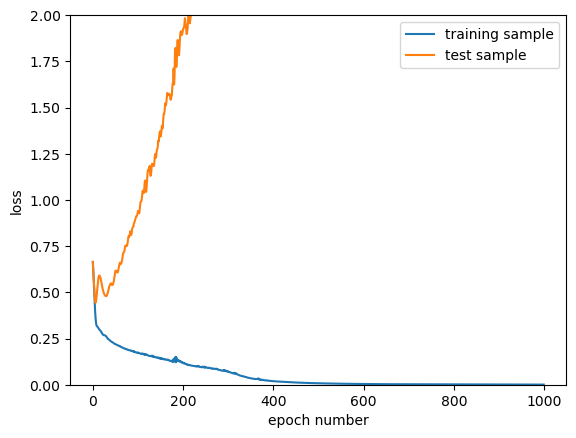

In [32]:
fig, ax = plt.subplots()

ax.plot(range(len(training_loss_vs_epoch)), training_loss_vs_epoch)
ax.plot(range(len(test_loss_vs_epoch)), test_loss_vs_epoch)

ax.set_ylim(0, 2)
ax.set_xlabel("epoch number")
ax.set_ylabel("loss")

ax.legend(["training sample", "test sample"])

None

<br><br><br><br><br>

## Goodness of fit metrics

### Loss function

...

### Confusion matrix

...

### Quantities derived from the confusion matrix

...

### ROC curve

...

### Area under the ROC curve

...

<br><br><br><br><br>

## Next: your main project!